In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import mne

In [2]:
file_path = '/Users/e4/E-2/DEAP_DATA/s01.dat'
data = np.fromfile(file_path, dtype=np.float32)

n_channels = 40       
n_time_points = 8064  
n_trials = len(data) // (n_channels * n_time_points)
data = data[:n_trials * n_channels * n_time_points].reshape(n_trials, n_channels, n_time_points)
subset = data[:10] 
print(subset.shape)

(10, 40, 8064)


In [3]:
if np.isnan(subset).any() or np.isinf(subset).any(): 
    subset = np.nan_to_num(subset)
    print("NaNs or Infs found and replaced.")
else:
    print("No NaNs or Infs found.")

NaNs or Infs found and replaced.


In [4]:
subset_flattened = subset.reshape(n_channels, 10 * n_time_points)
info = mne.create_info(ch_names=[f'EEG {i+1}' for i in range(n_channels)], sfreq=128, ch_types='eeg')
raw = mne.io.RawArray(subset_flattened, info)
print(raw.info)
raw.filter(l_freq=1.0, h_freq=50.0, fir_design='firwin')
raw.crop(tmax=60)

Creating RawArray with float64 data, n_channels=40, n_times=80640
    Range : 0 ... 80639 =      0.000 ...   629.992 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 7, EEG 8, EEG 9, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 128.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawArray | 40 x 7681 (60.0 s), ~2.4 MB, data loaded>

In [5]:
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)  
print(
    f"the (cropped) sample data object has {n_time_samps} time samples and "
    f"{n_chan} channels."
)
print(f"The last time sample is at {time_secs[-1]} seconds.")
print("The first few channel names are {}.".format(", ".join(ch_names[:3])))
print()  

print("bad channels:", raw.info["bads"])  
print(raw.info["sfreq"], "Hz")  
print(raw.info["description"], "\n")  

print(raw.info)

the (cropped) sample data object has 7681 time samples and 40 channels.
The last time sample is at 60.0 seconds.
The first few channel names are EEG 1, EEG 2, EEG 3.

bad channels: []
128.0 Hz
None 

<Info | 7 non-empty values
 bads: []
 ch_names: EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 7, EEG 8, EEG 9, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 128.0 Hz
>


In [6]:
print(raw.time_as_index(20))
print(raw.time_as_index([20, 30, 40]), "\n")

print(np.diff(raw.time_as_index([1, 2, 3])))

[2560]
[2560 3840 5120] 

[128 128]


In [7]:
eeg = raw.copy().pick(picks=["eeg"])
print(len(raw.ch_names), "→", len(eeg.ch_names))

40 → 40


In [8]:
raw_temp = raw.copy()
print("Number of channels in raw_temp:")
print(len(raw_temp.ch_names), end=" → drop two → ")
raw_temp.drop_channels(["EEG 31", "EEG 20"])
print(len(raw_temp.ch_names), end=" → pick three → ")
raw_temp.pick([ "EEG 17"])
print(len(raw_temp.ch_names))

Number of channels in raw_temp:
40 → drop two → 38 → pick three → 1


In [9]:
channel_names = [ "EEG 3", "EEG 2", "EEG 1"]
eog_and_frontal_eeg = raw.copy().reorder_channels(channel_names)
print(eog_and_frontal_eeg.ch_names)

['EEG 3', 'EEG 2', 'EEG 1']


In [10]:
raw.rename_channels({"EEG 1": "stimc"})

<RawArray | 40 x 7681 (60.0 s), ~2.4 MB, data loaded>

In [11]:
print(raw.ch_names[-3:])
channel_renaming_dict = {name: name.replace(" ", "_") for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict)
print(raw.ch_names[-3:])

['EEG 38', 'EEG 39', 'EEG 40']
['EEG_38', 'EEG_39', 'EEG_40']


In [12]:
raw_selection = raw.copy().crop(tmin=10, tmax=12.5)
print(raw_selection)

<RawArray | 40 x 321 (2.5 s), ~135 kB, data loaded>


In [13]:
print(raw_selection.times.min(), raw_selection.times.max())
raw_selection.crop(tmin=1)
print(raw_selection.times.min(), raw_selection.times.max())

0.0 2.5
0.0 1.5


In [14]:
raw_selection1 = raw.copy().crop(tmin=30, tmax=30.1) 
raw_selection2 = raw.copy().crop(tmin=40, tmax=41.1)  
raw_selection3 = raw.copy().crop(tmin=50, tmax=51.3)  
raw_selection1.append([raw_selection2, raw_selection3])  
print(raw_selection1.times.min(), raw_selection1.times.max())

0.0 2.515625


In [15]:
sampling_freq = raw.info["sfreq"]
start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)

(array([[ 1.14991976e+36,  3.09779965e+35,  1.34978133e+36,
         3.63919300e+35,  1.06051745e+36,  5.68740557e+35,
         1.00185736e+36,  4.07787430e+35,  1.30141780e+36,
        -1.03681693e+35,  1.74848340e+36, -3.02631878e+35,
         1.33294995e+36,  8.98656701e+35, -9.57216866e+35,
         4.22032760e+36, -5.27926914e+36,  9.09037323e+36,
        -1.03396197e+37,  1.35666439e+37, -1.88671716e+37,
        -1.12219438e+38, -1.38731465e+37,  1.36477206e+37,
        -1.05879223e+37,  9.17868915e+36, -5.63991208e+36,
         4.21947195e+36, -1.31490089e+36,  7.51940372e+35,
         1.02149885e+36, -5.68172831e+35,  1.33753030e+36,
        -3.12229968e+35,  6.42004927e+35,  4.28393828e+35,
        -3.07785838e+34,  8.00552522e+35, -4.95266123e+34,
         1.56149831e+35,  1.13810901e+36, -1.63093087e+36,
         3.33919205e+36, -4.21585448e+36,  5.90383722e+36,
        -6.60483574e+36,  7.67779452e+36,  5.59577903e+37,
         7.77610209e+36, -6.94730171e+36,  6.19141021e+

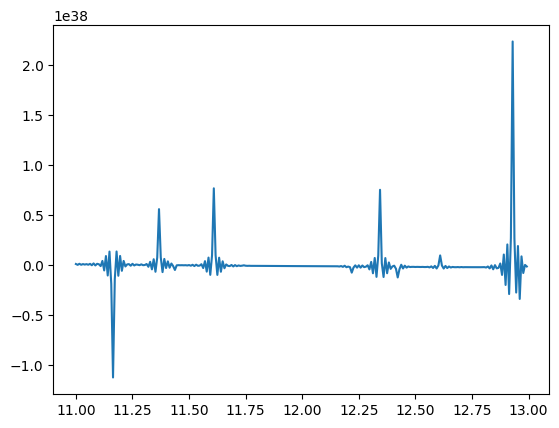

In [16]:
x = raw_selection[1]
y = raw_selection[0].T
plt.plot(x, y)